In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'Russia'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(127564, 7)
CPU times: user 33.2 s, sys: 278 ms, total: 33.5 s
Wall time: 33.7 s


In [5]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/army/,NaN,Россия,Начался осенний призыв '99,В минувший четверг президент РФ Борис Ельцин п...,Россия
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/bezhentsy/,NaN,Россия,Число беженцев в Ингушетии достигло 90 тысяч,"Мирные жители продолжают покидать Чечню, переб...",Россия


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

<unknown>:2: DeprecationWarning: invalid escape sequence \d


CPU times: user 519 ms, sys: 28 ms, total: 547 ms
Wall time: 545 ms


* clean text

In [7]:
import preprocessing_tools as pr

In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 21.9 s, sys: 179 ms, total: 22.1 s
Wall time: 22.1 s


In [9]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/army/,NaN,Россия,Начался осенний призыв '99,в минувший четверг президент рф борис ельцин п...,Россия,"[(1999, 10, 01)]",1999,10
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/bezhentsy/,NaN,Россия,Число беженцев в Ингушетии достигло 90 тысяч,мирные жители продолжают покидать чечню переби...,Россия,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 3min 46s, sys: 3.8 ms, total: 3min 46s
Wall time: 3min 46s


* lemmatization

In [12]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 5min 25s, sys: 492 ms, total: 5min 26s
Wall time: 5min 26s


* add docID

In [13]:
df['docID'] = list(range(df.shape[0]))

In [14]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[минувший, четверг, президент, рф, борис_ельци..."
1,1,1999,10,"[мирный, житель, продолжать, покидать, чечня, ..."


In [15]:
print(df.shape)
df.isnull().sum()

(127564, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [16]:
df.year.min()

1999

## model

* prepare

In [17]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 1.99 s, sys: 260 ms, total: 2.25 s
Wall time: 2.25 s


In [18]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [19]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/Russia", num_batches=128)
CPU times: user 1min 6s, sys: 651 ms, total: 1min 7s
Wall time: 18.1 s


In [20]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [21]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=36e50f51-e206-49fe-b436-0f90207209d4, num_entries=35667)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #2am

#topic 2.........


In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

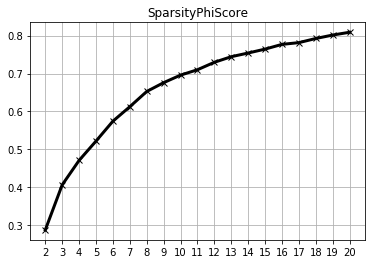

In [25]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [26]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.4, 0.5, 0.6, 0.7, 0.8]

In [27]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 8, 0.8: 2}

Text(0.5, 1.0, 'SparsityThetaScore')

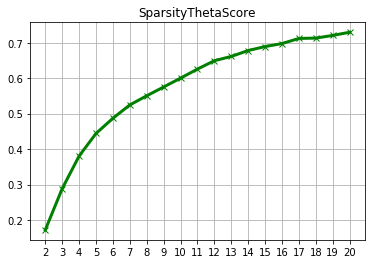

In [28]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [29]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [30]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 7, 0.7: 4}

Text(0.5, 1.0, 'PerplexityScore')

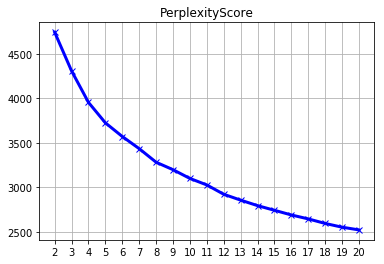

In [31]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [32]:
perplexity

[4743.140625,
 4308.1279296875,
 3954.203125,
 3724.353271484375,
 3570.958740234375,
 3434.198486328125,
 3281.608154296875,
 3197.7421875,
 3099.375732421875,
 3026.2744140625,
 2921.44140625,
 2855.5595703125,
 2793.71337890625,
 2741.35546875,
 2688.814208984375,
 2644.536376953125,
 2593.37890625,
 2551.35205078125,
 2520.802001953125]

### select the best model

In [33]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 8, 0.8: 2}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 3, 0.6: 7, 0.7: 4}


In [34]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


### print top words for each topics

In [35]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['станция' 'поезд' 'метро' 'линия' 'вода' 'авария' 'движение' 'дорога'
 'транспорт' 'метрополитен']
topic_1: ['мужчина' 'летний' 'полиция' 'ребёнок' 'женщина' 'следственный'
 'подозревать' 'полицейский' 'мвд' 'квартира']
topic_2: ['партия' 'выбор' 'кандидат' 'единый' 'выборы' 'избирательный' 'лидер'
 'процент' 'кпрф' 'голосование']
topic_3: ['закон' 'законопроект' 'гражданин' 'государственный' 'проект' 'поправка'
 'образование' 'внести' 'согласно' 'федерация']
topic_4: ['украина' 'крым' 'украинский' 'международный' 'республика' 'совет'
 'сторона' 'соглашение' 'санкция' 'государство']
topic_5: ['военный' 'вертолёт' 'оборона' 'минобороны' 'войско' 'военнослужащий'
 'сила' 'армия' 'флот' 'корабль']
topic_6: ['компания' 'миллиард' 'деньга' 'сумма' 'предприятие' 'средство' 'доллар'
 'стоимость' 'счёт' 'бюджет']
topic_7: ['мчс' 'погибший' 'школа' 'тело' 'взрыв' 'пострадавший' 'ребёнок'
 'студент' 'спасатель' 'университет']
topic_8: ['совет' 'заявление' 'письмо' 'проверка' 'журналист

### get topics-docs matrix

shape theta: (20, 127551)


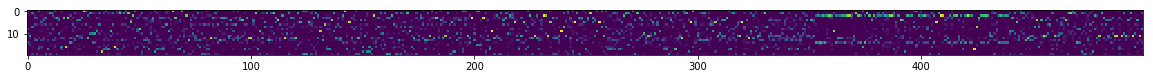

In [36]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [37]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
47000,0.0,0.000000,0.032873,0.394714,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.572413,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
47001,0.0,0.018536,0.428107,0.000000,0.0,0.000000,0.0,0.0,0.271056,0.000000,0.000000,0.000000,0.109836,0.000000,0.0,0.0,0.0,0.172465,0.0,0.0
47002,0.0,0.000000,0.000000,0.355121,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.333088,0.000000,0.311790,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
47003,0.0,0.113403,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.072961,0.604399,0.000000,0.000000,0.209236,0.0,0.0,0.0,0.000000,0.0,0.0
47004,0.0,0.031462,0.000000,0.000000,0.0,0.092034,0.0,0.0,0.021927,0.000000,0.000000,0.139936,0.044541,0.277217,0.0,0.0,0.0,0.392883,0.0,0.0


## DataViz

In [38]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.503872,0.000000,0.378198,0.0,...,0.0,0.000000,0.000000,0.0,0.11793,0.000000,0.0,0.000000,0.0,0.0
1,1,1999,10,0.064871,0.068242,0.000000,0.135542,0.302865,0.000000,0.0,...,0.0,0.012898,0.019203,0.0,0.00000,0.387551,0.0,0.000000,0.0,0.0
2,2,1999,10,0.000000,0.000000,0.290674,0.047509,0.017833,0.000000,0.0,...,0.0,0.641185,0.002800,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0
3,3,1999,10,0.008290,0.000000,0.000000,0.000000,0.000000,0.304913,0.0,...,0.0,0.211007,0.000000,0.0,0.00000,0.475790,0.0,0.000000,0.0,0.0
4,4,1999,10,0.084448,0.041262,0.000000,0.117841,0.140891,0.000000,0.0,...,0.0,0.137352,0.000000,0.0,0.00000,0.126674,0.0,0.014703,0.0,0.0


In [39]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 20)


topic_0   topic_1    topic_2    topic_3    topic_4    topic_5  \
year month                                                                    
1999 8       0.260805  0.011754   0.563477   0.003295   0.315541   0.519503   
     9       9.041427  3.211550  17.210888  18.802683  10.553605   7.553745   
     10     16.423464  2.094064  25.666128  21.146429   7.741576   9.602865   
     11     13.416191  2.532889  31.894106  20.450239  15.733693  13.816628   
     12     15.153383  4.964587  80.581398  28.624178  19.528397  19.850395   

              topic_6   topic_7    topic_8   topic_9   topic_10   topic_11  \
year month                                                                   
1999 8       0.074805  0.352441   0.540348  0.000000   0.233134   0.166086   
     9       6.137578  8.017307   9.347978  2.354887   4.865317  14.083908   
     10     13.504915  2.954964  10.911636  2.783119   4.034626  10.243581   
     11     15.633964  5.958221  16.170202  5.400217  10.936064  21.336578   
     12      9.336896  5.914688  26.248585  6.302165  14.218107  30.213184   

             topic_12  topic_13   topic_14   topic_15  topic_16   topic_17  \
year month                                                                   
1999 8       0.359794  0.000000   0.602599   0.999635  0.135290   0.280302   
     9      17.278440  2.975014  14.297712  32.676044  8.329052   5.352463   
     10     10.757990  3.959804   9.863401  15.003152  3.456959   3.846483   
     11     19.368111  6.474261  16.297743  23.501381  8.028272   6.164304   
     12     24.873529  6.422683  25.531630  43.742165  9.845922  10.735640   

            topic_18  topic_19  
year month                      
1999 8      0.000000  0.581191  
     9      2.034653  9.875750  
     10     1.215847  3.788997  
     11     1.768900  7.118036  
     12     2.632644  5.279821

### straightforward matrix heatmap

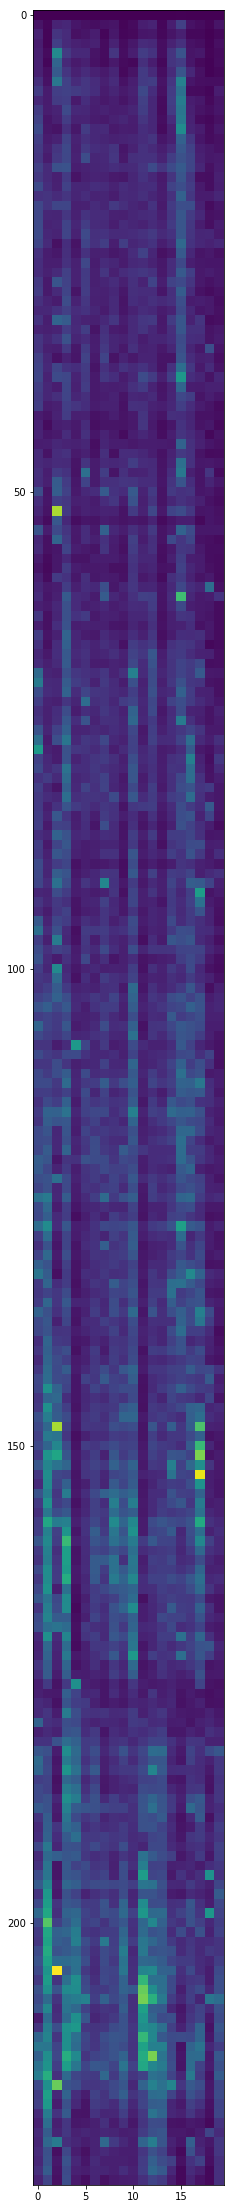

In [40]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [41]:
import pygal
from IPython.display import SVG, HTML

In [42]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [43]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [44]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [50]:
import joypy # !pip install joypy

In [51]:
print(joined.shape)
joined.head()

(127564, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.000000,0.000000,0.000000,0.503872,0.000000,0.378198,0.0,...,0.0,0.000000,0.000000,0.0,0.11793,0.000000,0.0,0.000000,0.0,0.0
1,1,1999,10,0.064871,0.068242,0.000000,0.135542,0.302865,0.000000,0.0,...,0.0,0.012898,0.019203,0.0,0.00000,0.387551,0.0,0.000000,0.0,0.0
2,2,1999,10,0.000000,0.000000,0.290674,0.047509,0.017833,0.000000,0.0,...,0.0,0.641185,0.002800,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0
3,3,1999,10,0.008290,0.000000,0.000000,0.000000,0.000000,0.304913,0.0,...,0.0,0.211007,0.000000,0.0,0.00000,0.475790,0.0,0.000000,0.0,0.0
4,4,1999,10,0.084448,0.041262,0.000000,0.117841,0.140891,0.000000,0.0,...,0.0,0.137352,0.000000,0.0,0.00000,0.126674,0.0,0.014703,0.0,0.0


In [52]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.000000,0.000000,0.000000,0.503872,0.000000,0.378198,...,0.000000,0.000000,0.0,0.11793,0.000000,0.0,0.000000,0.0,0.0,1999-10-01
1,1,1,1999,10,0.064871,0.068242,0.000000,0.135542,0.302865,0.000000,...,0.012898,0.019203,0.0,0.00000,0.387551,0.0,0.000000,0.0,0.0,1999-10-01
2,2,2,1999,10,0.000000,0.000000,0.290674,0.047509,0.017833,0.000000,...,0.641185,0.002800,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,1999-10-01
3,3,3,1999,10,0.008290,0.000000,0.000000,0.000000,0.000000,0.304913,...,0.211007,0.000000,0.0,0.00000,0.475790,0.0,0.000000,0.0,0.0,1999-10-01
4,4,4,1999,10,0.084448,0.041262,0.000000,0.117841,0.140891,0.000000,...,0.137352,0.000000,0.0,0.00000,0.126674,0.0,0.014703,0.0,0.0,1999-10-01


In [53]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(3061536, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [54]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(2551280, 3)


topic_8     127564
topic_13    127564
topic_14    127564
topic_6     127564
topic_2     127564
topic_11    127564
topic_3     127564
topic_4     127564
topic_10    127564
topic_15    127564
topic_18    127564
topic_16    127564
topic_9     127564
topic_7     127564
topic_19    127564
topic_17    127564
topic_5     127564
topic_0     127564
topic_12    127564
topic_1     127564
Name: topic, dtype: int64

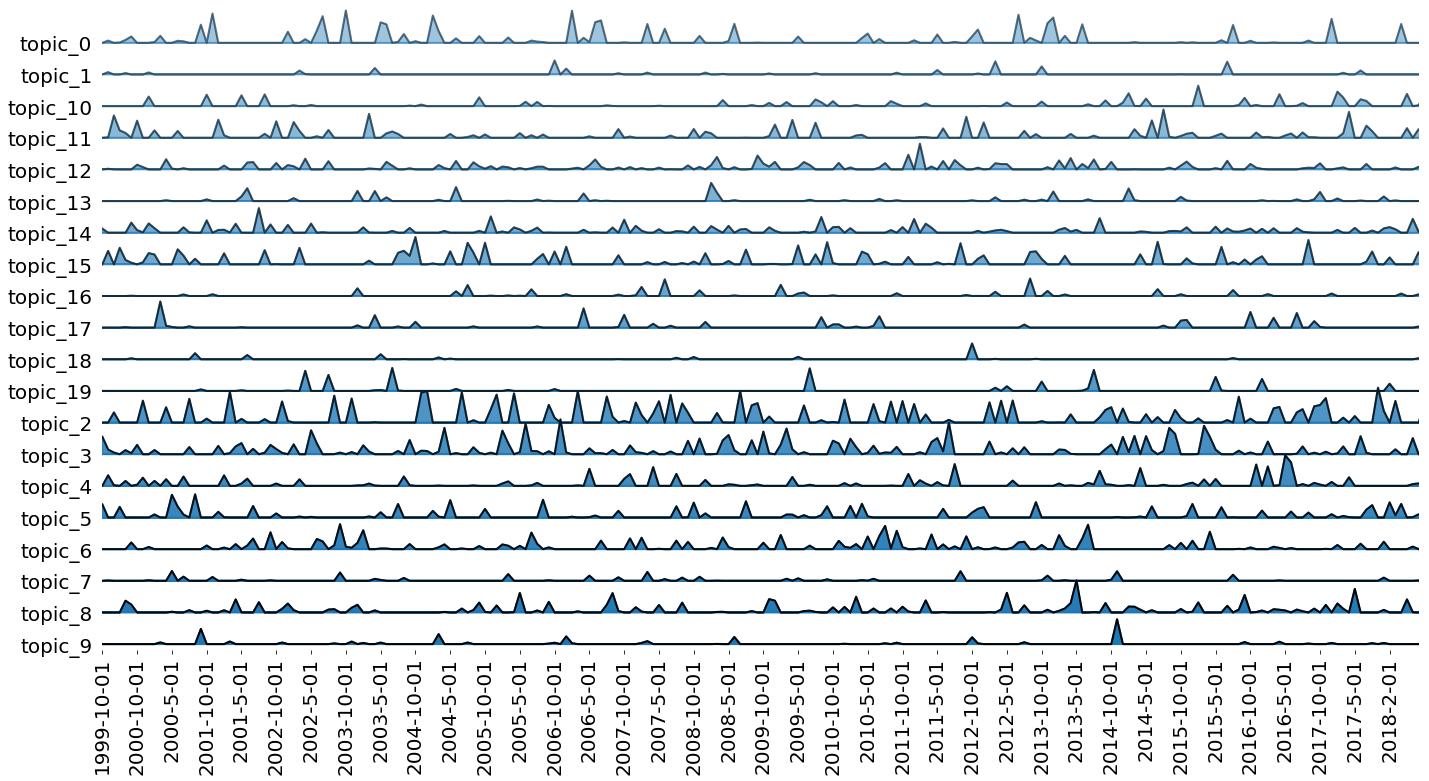

In [55]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [56]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")